In [153]:
import os
import io 
import json
import math
from PIL import Image 
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import numpy as np
from torchvision.models import resnet18
import torchvision.transforms as transforms
from sklearn.metrics.pairwise import cosine_similarity

import qdrant_client
from llama_index.core import SimpleDirectoryReader, StorageContext, Settings
from llama_index.core.schema import ImageNode
from llama_index.core.schema import ImageDocument
from llama_index.vector_stores.qdrant import QdrantVectorStore
from llama_index.core.response.notebook_utils import display_source_node
from llama_index.core.indices.multi_modal.base import MultiModalVectorStoreIndex
from llama_index.embeddings.clip import ClipEmbedding
from llama_index.core.node_parser import SentenceSplitter
from llama_index.multi_modal_llms.ollama import OllamaMultiModal
from llama_index.embeddings.huggingface import HuggingFaceEmbedding

##设置embeding 模型和llva模型
Settings.embed_model = HuggingFaceEmbedding(model_name="BAAI/bge-small-en-v1.5")
mm_model = OllamaMultiModal(model="llava")

##将图片转换为patch
def img_to_patch(input_path, output_path, rows, cols):
    # 确保输出文件夹存在
    os.makedirs(output_path, exist_ok=True)

    # 遍历文件夹中的每个图像文件
    for filename in tqdm(os.listdir(input_path)):
        # 构建图像文件的完整路径
        image_file = os.path.join(input_path, filename)

        # 打开图像文件
        image = Image.open(image_file)

        # 获取图像的宽度和高度
        width, height = image.size

        # 计算每个块的宽度和高度
        patch_width = math.floor(width / cols)
        patch_height = math.floor(height / rows)

        # 遍历每个块的行和列
        for row in range(rows):
            for col in range(cols):
                # 计算当前块的边界框
                left = col * patch_width
                top = row * patch_height
                right = (col + 1) * patch_width
                bottom = (row + 1) * patch_height

                # 提取当前块的图像
                patch = image.crop((left, top, right, bottom))

                # 构造输出文件名
                filename_without_ext = os.path.splitext(filename)[0]
                patch_filename = f"{filename_without_ext}_patch_{row}_{col}.jpg"

                # 保存当前块的图像
                patch_path = os.path.join(output_path, patch_filename)
                patch.save(patch_path)

        # print(f"Saved patch: {patch_path}")
    return input_path, output_path

def leaf_indexing(leaf_path):
    documents = SimpleDirectoryReader(leaf_path).load_data()
    node_parser = SentenceSplitter.from_defaults()
    leaf_nodes = node_parser.get_nodes_from_documents(documents)
    ##需要补充一个Qdrant库(判断是否需要重新indexing)
    index = MultiModalVectorStoreIndex(leaf_nodes, show_progress=True)
    return index

def leaf_retriever(leaf_index, query_img, topk):
    """" Note: query must a imge_path"""
    # leaf_index = index
    leaf = leaf_index.as_retriever(similarity_top_k=topk, image_similarity_top_k=topk)
    response = leaf.image_to_image_retrieve(query_img)  ##query是image_path
    return response  ##topk=10

def AutoMerge(base_retriever):
    retrieved_image_path = []
    retrieved_image_score = []
    for res_node in base_retriever:
        if isinstance(res_node.node, ImageNode):
            retrieved_image_path.append(res_node.node.image_path)
            retrieved_image_score.append(res_node.score)
        else:
            print('Wrong, please input ImageNode')

    retrieved_image_data = {}

    for path, score in zip(retrieved_image_path, retrieved_image_score):
        doc_name = path.split('\\')[-1].split('_patch')[0]  # 提取文档名称
        if doc_name in retrieved_image_data:
            retrieved_image_data[doc_name].append(score)
        else:
            retrieved_image_data[doc_name] = [score]

    merge_image = [[doc_name+'.jpg', sum(scores) / len(scores)] for doc_name, scores in retrieved_image_data.items()]

    return merge_image

def rerank_embedding(image_path):
    # 加载预训练的 ResNet18 模型
    model = resnet18(pretrained=True)
    model.fc = torch.nn.Identity()  # 移除分类层，保留特征提取部分
    model.eval()

    # 图像预处理
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # 加载并预处理图像
    image = Image.open(image_path).convert('RGB')
    image = preprocess(image)
    image = image.unsqueeze(0)

    # 使用模型获取图像的嵌入向量
    with torch.no_grad():
        embedding = model(image)

    return embedding

def Rerank(orig_img, parent_img, merge_image):
    orig_img_embedding = rerank_embedding(orig_img)

    similarity_scores = []
    img_files = os.listdir(parent_img)  # 获取父文件夹内的所有文件和文件夹

    for img_path, score in tqdm(merge_image):
        if img_path in img_files:  # 检查文件名是否存在于父文件夹中
            parent_img_path = os.path.join(parent_img, img_path)  # 构建完整的文件路径

            # 计算图像相似度
            img_similarity = torch.cosine_similarity(orig_img_embedding, rerank_embedding(parent_img_path))
            similarity = img_similarity.item()
            weighted_score = np.mean([similarity, score])
            similarity_scores.append((parent_img_path, similarity, weighted_score))

    similarity_scores.sort(key=lambda x: x[2], reverse=True)

    return similarity_scores[0:3]   ##topk=3

def parent_retriever(img_list):
    return img, text, metadata  ##topk=1 * 3

def chatllm(img, text, metadata):
    return response.text

In [430]:
def parent_indexing(parent_path):
    documents = SimpleDirectoryReader(parent_path).load_data()
    node_parser = SentenceSplitter.from_defaults()
    leaf_nodes = node_parser.get_nodes_from_documents(documents)
    ##需要补充一个Qdrant库(判断是否需要重新indexing)
    index = MultiModalVectorStoreIndex(leaf_nodes, show_progress=True)
    return index

def parent_retriever(parent_index, rerank_list):
    """" Note: query must a imge_path"""
    # leaf_index = index
    parent_response = []
    average_score = []
    for path, score, score2 in rerank_list:
        # parent_retriever(parent_index, path)
        parent = parent_index.as_retriever(similarity_top_k=1, image_similarity_top_k=1)
        response = parent.image_to_image_retrieve(path)  ##query是image_path
        parent_response.append(response)
        average_score.append(score2)
    return parent_response, average_score  ##topk=10

def plot_images(image_paths):
    # Initialize a counter to track the number of images shown
    images_shown = 0
    # Set the figure size for the entire plot
    plt.figure(figsize=(16, 9))
    # Iterate through each image path in the provided list
    for img_path in image_paths:
        # Check if the file exists
        if os.path.isfile(img_path):
            # Open the image using the Image module
            image = Image.open(img_path)
            # Create a subplot for the current image in a 2x3 grid
            plt.subplot(2, 3, images_shown + 1)
            # Display the image in the subplot
            plt.imshow(image)
            # Remove x and y ticks for clarity
            plt.xticks([])
            plt.yticks([])
            # Increment the counter for images shown
            images_shown += 1
            # Break the loop if 9 images have been shown
            if images_shown >= 9:
                break

def parent_retrieved_vis(parent_response, average_score):
    print(average_score)
    retrieved_image = []
    # retrieved_image_score = []
    retrieved_text = []
    retrieved_metadata = []
    for res_node in parent_response:
        for i in res_node:
            retrieved_image.append(i.metadata['file_path'])
            # retrieved_image_score.append(average_score)
            retrieved_text.append(i.text)
            retrieved_metadata.append(i.metadata)
    plot_images(retrieved_image)        
    
    return retrieved_image, retrieved_text, retrieved_metadata

img, txt, metadata = parent_retrieved_vis()

image_documents = [ImageDocument(image_path=img_path)]
for res_img in img:
    image_documents.append(ImageDocument(image_path=res_img))
context_str = "".join(txt)
metadata_str = metadata

def chatllm(img, text, metadata):
    return response.text

In [413]:
for res_node in parent_response:
    for i in res_node:
        print(i.metadata['file_path'])

E:\RAG_LLM\wuhan_test_img\36_09000200121905231539392928V.jpg
E:\RAG_LLM\wuhan_test_img\14_09000200121706181746066569G.jpg
E:\RAG_LLM\wuhan_test_img\51_09000200121905091456090729T.jpg


In [368]:
parent_index=parent_indexing('E:/RAG_LLM/wuhan_test_img')

Generating image embeddings: 100%|██████████| 100/100 [00:17<00:00,  5.71it/s]


In [378]:
parent_response, score = parent_retriever(parent_index, rerank_list)

In [391]:
parent_response

[[NodeWithScore(node=ImageNode(id_='74a56b54-f328-4e7c-9466-ca66c248cdc6', embedding=None, metadata={'file_path': 'E:\\RAG_LLM\\wuhan_test_img\\36_09000200121905231539392928V.jpg', 'file_name': '36_09000200121905231539392928V.jpg', 'file_type': 'image/jpeg', 'file_size': 825211, 'creation_date': '2024-04-02', 'last_modified_date': '2024-03-31'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='79463e54-b70d-49d3-b3f2-420b9d26e2ed', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'file_path': 'E:\\RAG_LLM\\wuhan_test_img\\36_09000200121905231539392928V.jpg', 'file_name': '36_09000200121905231539392928V.jpg', 'file_type': 'image/jpeg', 'file_size': 825211, 'creation_date': '2024-04-02', 'last_modified_date': '

[0.8199089435674096, 0.7767880854693828, 0.775867379783942]


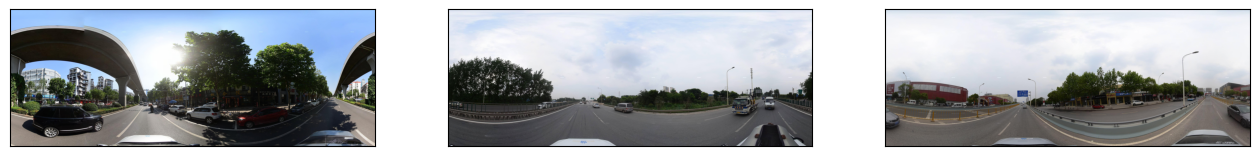

In [429]:
parent_retrieved_vis(parent_response, score)

In [361]:
%%time
rerank_list = Rerank(orig_img = 'E:/RAG_LLM/37_09000200121905231554463318V.jpg', 
       parent_img = 'E:/RAG_LLM/wuhan_test_img',
       merge_image = listt)

c:\Users\20143\.conda\envs\torch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\20143\.conda\envs\torch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 9/9 [00:03<00:00,  2.48it/s]

CPU times: total: 32.1 s
Wall time: 3.97 s


In [365]:
rerank_list

[('E:/RAG_LLM/wuhan_test_img\\36_09000200121905231539392928V.jpg',
  0.8328220844268799,
  0.8199089435674096),
 ('E:/RAG_LLM/wuhan_test_img\\14_09000200121706181746066569G.jpg',
  0.7695155739784241,
  0.7767880854693828),
 ('E:/RAG_LLM/wuhan_test_img\\51_09000200121905091456090729T.jpg',
  0.7698909640312195,
  0.775867379783942)]

In [352]:
listt

[['29_09000200121905121110593828Y.jpg', 0.7982917539255865],
 ['36_09000200121905231539392928V.jpg', 0.8069958027079394],
 ['100_09000200121905121423334232P.jpg', 0.8039958486691555],
 ['39_09000200121905231542018508V.jpg', 0.800071179500962],
 ['59_09000200121905211246096272P.jpg', 0.7897753453215711],
 ['14_09000200121706181746066569G.jpg', 0.7840605969603416],
 ['102_09000200121905121424245032P.jpg', 0.7835369407877236],
 ['51_09000200121905091456090729T.jpg', 0.7818437955366646],
 ['101_09000200121905121424028412P.jpg', 0.7813383841415004]]

In [ ]:
leaf_index = leaf_indexing(leaf_path='test/')

In [173]:
resp = leaf_retriever(leaf_index,
                      query_img='E:/RAG_LLM/37_09000200121905231554463318V.jpg',
                      topk=10)

# resp

In [174]:
resp

[NodeWithScore(node=ImageNode(id_='b34e69a1-68bb-454e-8bf6-3dd6f886f77c', embedding=None, metadata={'file_path': 'e:\\RAG_LLM\\test\\29_09000200121905121110593828Y_patch_0_7.jpg', 'file_name': '29_09000200121905121110593828Y_patch_0_7.jpg', 'file_type': 'image/jpeg', 'file_size': 61471, 'creation_date': '2024-04-02', 'last_modified_date': '2024-04-02'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='6bf0fbfb-b53b-402f-8ec7-52d3f4f6ea20', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'file_path': 'e:\\RAG_LLM\\test\\29_09000200121905121110593828Y_patch_0_7.jpg', 'file_name': '29_09000200121905121110593828Y_patch_0_7.jpg', 'file_type': 'image/jpeg', 'file_size': 61471, 'creation_date': '2024-04-02', 'last_

In [154]:
img_to_patch(input_path = 'E:/BaiduNetdiskDownload/wuhan_test_img', 
          output_path = 'test/', 
          rows = 1, 
          cols = 8)

100%|██████████| 100/100 [00:07<00:00, 13.01it/s]


('E:/BaiduNetdiskDownload/wuhan_test_img', 'test/')

c:\Users\20143\.conda\envs\torch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [19]:
# Define a function to plot images given a list of image paths
def plot_images(image_paths):
    # Initialize a counter to track the number of images shown
    images_shown = 0
    # Set the figure size for the entire plot
    plt.figure(figsize=(16, 9))
    # Iterate through each image path in the provided list
    for img_path in image_paths:
        # Check if the file exists
        if os.path.isfile(img_path):
            # Open the image using the Image module
            image = Image.open(img_path)
            # Create a subplot for the current image in a 2x3 grid
            plt.subplot(2, 10, images_shown + 1)
            # Display the image in the subplot
            plt.imshow(image)
            # Remove x and y ticks for clarity
            plt.xticks([])
            plt.yticks([])
            # Increment the counter for images shown
            images_shown += 1
            # Break the loop if 9 images have been shown
            if images_shown >= 9:
                break

## define retrive function
def retrieve_display(retrieval_results):
    retrieved_image = []
    retrieved_image_score = []
    retrieved_text = []
    retrieved_metadata = []
    for res_node in retrieval_results:
        if isinstance(res_node.node, ImageNode):
            retrieved_image.append(res_node.node.image_path)
            retrieved_image_score.append(res_node.score)
            retrieved_text.append(res_node.text)
            retrieved_metadata.append(res_node.metadata)
            display_source_node(res_node, source_length=200)
        else:
            display_source_node(res_node, source_length=200)
            # retrieved_text.append(res_node.text)

    return retrieved_image, retrieved_text, retrieved_image_score, retrieved_metadata

In [125]:
from llama_index.core.schema import ImageNode, BaseNode
from llama_index.core.schema import NodeRelationship, RelatedNodeInfo

parent_node = ImageNode(id_= '01',
                        image_path='15728_114.207953_30.52452144.png',
                          text='这里是无锡的一条小路',
                          relationships={NodeRelationship.CHILD: BaseNode.as_related_node_info(image_node2),
                                         NodeRelationship.CHILD: BaseNode.as_related_node_info(image_node1)},
                          metadata={
                              "Boring": 0.342,
                          })

image_node1 = ImageNode(id_= '001',
                        image_path='20.695691_-103.362361_51413371fdc9f049260042da_Guadalajara.JPG',
                          text='这里是杭州的一条小路',
                          # relationships={NodeRelationship.PARENT: BaseNode.as_related_node_info(parent_node)},
                          metadata={
                              "Boring": 0.223,
                          })

image_node2 = ImageNode(id_= '002',
                        image_path='20.698723_-103.385711_51413409fdc9f049260044f1_Guadalajara.JPG',
                          text='这里是新加坡的一条街道',
                        #   relationships={NodeRelationship.PARENT: BaseNode.as_related_node_info(parent_node)},
                          metadata={
                              'Boring': 0.999,
                          })



image_nodesss = [parent_node, image_node1,image_node2]
image_nodesss

[ImageNode(id_='01', embedding=None, metadata={'Boring': 0.342}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.CHILD: '5'>: RelatedNodeInfo(node_id='001', node_type=<ObjectType.IMAGE: '2'>, metadata={'Boring': 0.223}, hash='29a148e6eee5da7fba90936e5138f3a125d0296f73633a983e52ed7ac38ef3eb')}, text='这里是无锡的一条小路', start_char_idx=None, end_char_idx=None, text_template='{metadata_str}\n\n{content}', metadata_template='{key}: {value}', metadata_seperator='\n', image=None, image_path='15728_114.207953_30.52452144.png', image_url=None, image_mimetype=None, text_embedding=None),
 ImageNode(id_='001', embedding=None, metadata={'Boring': 0.223}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, text='这里是杭州的一条小路', start_char_idx=None, end_char_idx=None, text_template='{metadata_str}\n\n{content}', metadata_template='{key}: {value}', metadata_seperator='\n', image=None, image_path='20.695691_-103.362361_51413371fdc9f0

In [126]:
from llama_index.core.node_parser import get_leaf_nodes, get_root_nodes
leaf_nodes = get_leaf_nodes(image_nodesss)
leaf_nodes

[ImageNode(id_='001', embedding=None, metadata={'Boring': 0.223}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, text='这里是杭州的一条小路', start_char_idx=None, end_char_idx=None, text_template='{metadata_str}\n\n{content}', metadata_template='{key}: {value}', metadata_seperator='\n', image=None, image_path='20.695691_-103.362361_51413371fdc9f049260042da_Guadalajara.JPG', image_url=None, image_mimetype=None, text_embedding=None),
 ImageNode(id_='002', embedding=None, metadata={'Boring': 0.999}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, text='这里是新加坡的一条街道', start_char_idx=None, end_char_idx=None, text_template='{metadata_str}\n\n{content}', metadata_template='{key}: {value}', metadata_seperator='\n', image=None, image_path='20.698723_-103.385711_51413409fdc9f049260044f1_Guadalajara.JPG', image_url=None, image_mimetype=None, text_embedding=None)]

In [127]:
all = MultiModalVectorStoreIndex(image_nodesss)
base = MultiModalVectorStoreIndex(leaf_nodes)

In [135]:
from llama_index.core.retrievers import AutoMergingRetriever
basic = base.as_retriever(image_similarity_top_k=5)
resp = basic.image_to_image_retrieve(img_path)

# retriever = AutoMergingRetriever(basic, all, verbose=True)

resp.

In [136]:
resp

[NodeWithScore(node=ImageNode(id_='001', embedding=None, metadata={'Boring': 0.223}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, text='这里是杭州的一条小路', start_char_idx=None, end_char_idx=None, text_template='{metadata_str}\n\n{content}', metadata_template='{key}: {value}', metadata_seperator='\n', image=None, image_path='20.695691_-103.362361_51413371fdc9f049260042da_Guadalajara.JPG', image_url=None, image_mimetype=None, text_embedding=None), score=0.5996515642932855),
 NodeWithScore(node=ImageNode(id_='002', embedding=None, metadata={'Boring': 0.999}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, text='这里是新加坡的一条街道', start_char_idx=None, end_char_idx=None, text_template='{metadata_str}\n\n{content}', metadata_template='{key}: {value}', metadata_seperator='\n', image=None, image_path='20.698723_-103.385711_51413409fdc9f049260044f1_Guadalajara.JPG', image_url=None, image_mimetype=None, text_embedding=None), score=0.4840

In [ ]:
from llama_index.core.node_parser import HierarchicalNodeParser
from llama_index.core.node_parser import get_leaf_nodes

# 结构化node划分，2048-->512-->128
node_parser = HierarchicalNodeParser.from_defaults(
    chunk_sizes=[512, 128, 64]
)
nodes = node_parser.get_nodes_from_documents(
    [Document(text=text,
          metadata={
              "filename":"bbb",
              "categery":"kkk"
          })], show_progress=False
)
print(len(nodes))

##把叶子节点提取出来
leaf_nodes = get_leaf_nodes(nodes)
print(len(leaf_nodes))

In [26]:
from llama_index.core.indices import MultiModalVectorStoreIndex
from llama_index.core.node_parser import SentenceSplitter

documents = SimpleDirectoryReader("E:/RAG_LLM/test/").load_data()
node_parser = SentenceSplitter.from_defaults()
leaf_nodes = node_parser.get_nodes_from_documents(documents)

# index = MultiModalVectorStoreIndex.from_documents(
#     documents=documents,
#     # storage_context=storage_context,
#     show_progress=True
# )

In [29]:
leaf_nodes[0].relationships

{<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='2e2751b0-0c6f-4549-8d7f-fda870cd87ba', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'file_path': 'E:\\RAG_LLM\\test\\11_09000200011704231032257502R_patch_0_0.jpg', 'file_name': '11_09000200011704231032257502R_patch_0_0.jpg', 'file_type': 'image/jpeg', 'file_size': 81696, 'creation_date': '2024-04-02', 'last_modified_date': '2024-04-02'}, hash='9a8e1fe51d842a9b2e15c31a0dccc8fb598ef7fe28108d9c8a149f7fe611b23c'),
 <NodeRelationship.NEXT: '3'>: RelatedNodeInfo(node_id='c451784e-d2c0-4591-a8c7-1f27b9f21905', node_type=<ObjectType.IMAGE: '2'>, metadata={}, hash='44136fa355b3678a1146ad16f7e8649e94fb4fc21fe77e8310c060f61caaff8a')}

In [23]:
##使用.as_retriever创建一个检索器
urban_retrieve = index.as_retriever(similarity_top_k=10, image_similarity_top_k=10)

In [ ]:
from llama_index.core import VectorStoreIndex, StorageContext
from llama_index.core.storage.docstore import SimpleDocumentStore
from llama_index.core.retrievers import AutoMergingRetriever
##创建docstore储存node里面的doc
##参考https://docs.llamaindex.ai/en/stable/examples/docstore/DocstoreDemo/?h=simpledocumentstore
##参考https://blog.csdn.net/weixin_42608414/article/details/135666037
docstore = SimpleDocumentStore()
docstore.add_documents(nodes)

##创建容器把docstore放进去
storage_context = StorageContext.from_defaults(docstore=docstore)

#创建向量库索引index的数量等于叶子节点的数量
automerging_index = VectorStoreIndex(
    leaf_nodes,
    storage_context=storage_context)
##创建一个基于叶子节点的基础检索器
base_retriever = automerging_index.as_retriever(similarity_top_k=5)
##merge检索器在检索时只拿叶子节点和问题进行匹配，
##当某个父节点下的多数叶子节点都与问题匹配上则将该父节点作为context返回给LLM
retriever = AutoMergingRetriever(base_retriever, storage_context, verbose=True)

**Node ID:** aafecca9-0413-45db-9f44-7bd754cb31a1<br>**Similarity:** 0.7677246420917129<br>**Text:** <br>**Image:**

**Node ID:** d5f00ba0-737b-4844-8428-beef575066e2<br>**Similarity:** 0.7614236443957377<br>**Text:** <br>**Image:**

**Node ID:** d65f3e00-b49f-4acf-861a-f03bcf6d2098<br>**Similarity:** 0.7523525922548923<br>**Text:** <br>**Image:**

**Node ID:** a4df5543-68ee-4d68-8ae7-03187d0771c2<br>**Similarity:** 0.7437759981469682<br>**Text:** <br>**Image:**

**Node ID:** 8d5d2166-1bde-460a-a91f-9cb2e1d0fb49<br>**Similarity:** 0.7387070206351721<br>**Text:** <br>**Image:**

**Node ID:** 3ed73a27-435d-4e47-8752-dc0354c68a8a<br>**Similarity:** 0.727640101971869<br>**Text:** <br>**Image:**

**Node ID:** 37d8f4c5-dc0e-4f51-bc39-b7bd0bf26ae3<br>**Similarity:** 0.7218338384586993<br>**Text:** <br>**Image:**

**Node ID:** a4126970-a3ca-4663-8b8d-f085a0646146<br>**Similarity:** 0.7207748195974288<br>**Text:** <br>**Image:**

**Node ID:** 084ffe46-cade-48ce-942c-43791a1f177e<br>**Similarity:** 0.7142739635146919<br>**Text:** <br>**Image:**

**Node ID:** c3e7d21b-f547-4b0a-840a-6110320fdafd<br>**Similarity:** 0.7001438361093044<br>**Text:** <br>**Image:**

[0.7677246420917129, 0.7614236443957377, 0.7523525922548923, 0.7437759981469682, 0.7387070206351721, 0.727640101971869, 0.7218338384586993, 0.7207748195974288, 0.7142739635146919, 0.7001438361093044]


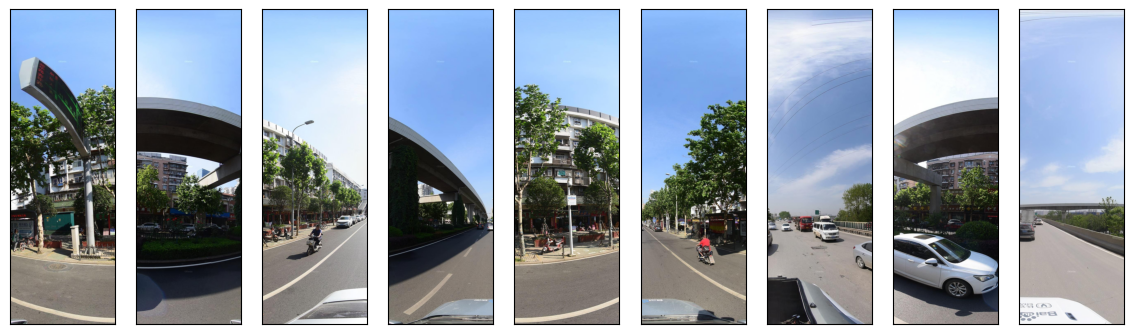

In [24]:
img_path = '37_09000200121905231554463318V.jpg'
# img, txt, score, metadata = retrieve_display(urban_retrieve.retrieve(img_path))  ##多模态检索
img, txt, score, metadata = retrieve_display(urban_retrieve.image_to_image_retrieve(img_path))  ##图像到图像检索

print(score)
plot_images(img[0:10])  ## visualization